# Working with DALI

## Prerequisites

The following code expects that cuCIM, matplotlib and DALI are installed on your system.
Please execute the following commands to install them.
(Assume that CUDA Toolkit 11.0 is available on the system.)

```
!conda install -c rapidsai -c conda-forge cucim cudatoolkit=11.0 matplotlib
# DALI doesn't have conda package for now.
!pip install --extra-index-url https://developer.download.nvidia.com/compute/redist --upgrade nvidia-dali-cuda110
```
or
```
!pip install cucim scipy scikit-image cupy-cuda110 matplotlib
!pip install --extra-index-url https://developer.download.nvidia.com/compute/redist --upgrade nvidia-dali-cuda110
```

In [1]:
#!conda install -c rapidsai -c conda-forge cucim cudatoolkit=11.0 matplotlib
#!pip install --extra-index-url https://developer.download.nvidia.com/compute/redist --upgrade nvidia-dali-cuda110

# or

#!pip install cucim scipy scikit-image cupy-cuda110 matplotlib
# Assume that CUDA Toolkit 11.0 is available on the systsem.
#!pip install --extra-index-url https://developer.download.nvidia.com/compute/redist --upgrade nvidia-dali-cuda110

## Interoperability with DALI through Python Custom Operator

### Using cuCIM's loader

The following example is using cuCIM's TIFF loader to load the image in CPU and process the image in CPU.

[Plugin: cucim.kit.cuslide] Loading...
[Plugin: cucim.kit.cuslide] Loading the dynamic library from: /home/gbae/.pyenv/versions/3.8.10/envs/cucim-3.8/lib/python3.8/site-packages/cucim/clara/cucim.kit.cuslide@21.10.00.so
[Plugin: cucim.kit.cuslide] loaded successfully. Version: 0
Initializing plugin: cucim.kit.cuslide (interfaces: [cucim::io::IImageFormat v0.1]) (impl: cucim.kit.cuslide)


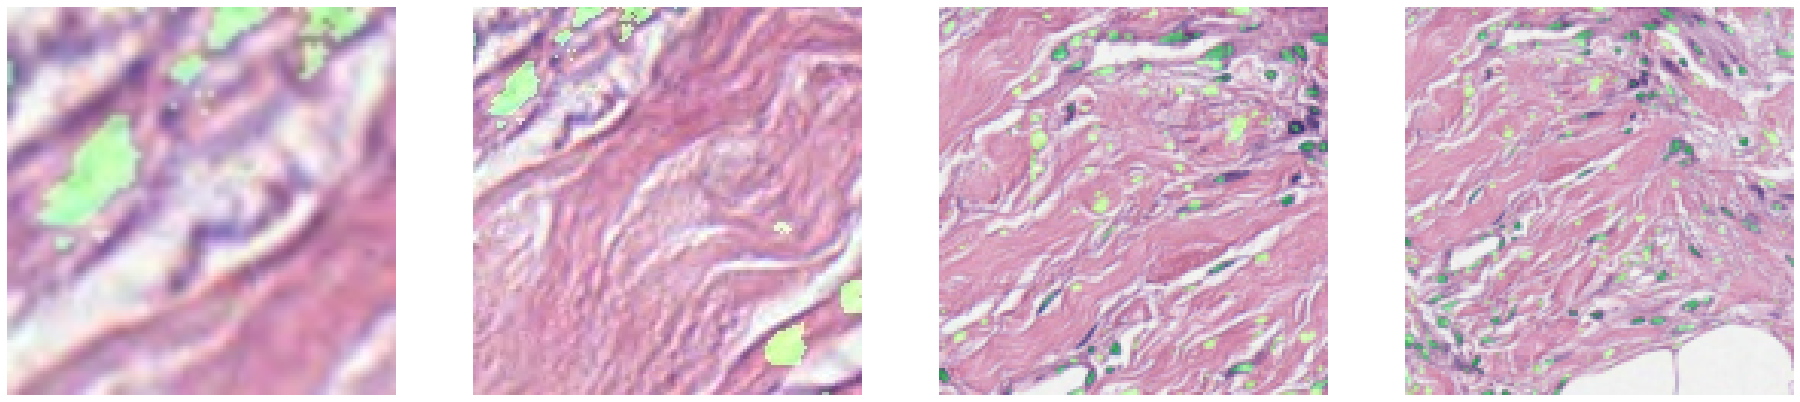

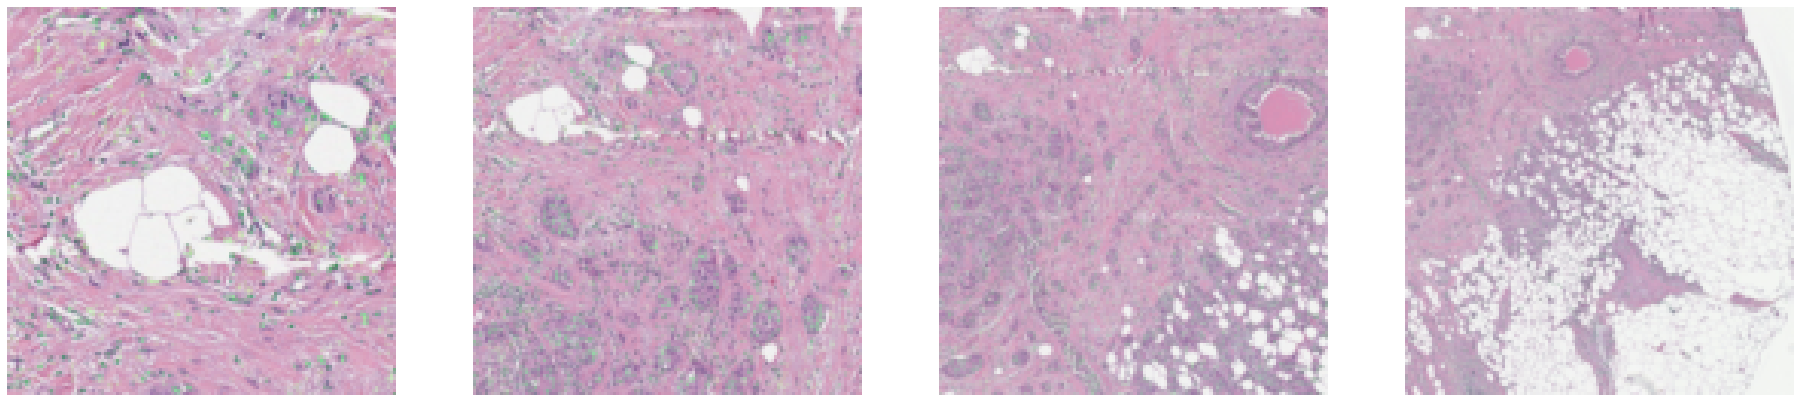

In [2]:
from cucim import CuImage
import nvidia.dali as dali
import nvidia.dali.fn as fn
import numpy as np

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
%matplotlib inline

def show_images(image_batch):
    columns = 4
    rows = (batch_size + 1) // (columns)
    fig = plt.figure(figsize = (32,(32 // columns) * rows))
    gs = gridspec.GridSpec(rows, columns)
    for j in range(rows*columns):
        plt.subplot(gs[j])
        plt.axis("off")
        plt.imshow(image_batch.at(j))

def filter_images(image):
    # Filter with cuCIM's operation methods (future work)
    #   example)
    #     from cucim.core import filters
    #     filtered_image = filters.sobel(image)
    filtered_image = image
    return filtered_image

def gen_image(file_name, location_list, size_list, level_list, batch_size):
    image = CuImage(file_name)
    batch = []
    for location, size, level in zip(location_list, size_list, level_list):
        region = image.read_region(location=location, size=size, level=level)
        batch.append(np.asarray(region))
        if (len(batch) == batch_size):
            yield (batch,)
            batch = []

file_name = "input/image.tif"
location_list = [    (5000, 5000), (5000, 5000), (5000, 5000), (5000, 5000), (5000, 5000), (5000, 5000), (5000, 5000), (5000, 5000)]
size_list     = [        (64, 64),   (128, 128),   (512, 512),   (800, 800),   (800, 800),   (800, 800),   (800, 800),   (800, 800)]
level_list    = [               0,            0,            0,            0,           1,             2,            3,            4]

batch_size = 4
num_threads = 1

pipe = dali.pipeline.Pipeline(batch_size = batch_size, num_threads = num_threads, device_id = 0,
                              exec_async=False, exec_pipelined=False, seed=99)

with pipe:
    input_image = fn.external_source(source=gen_image(file_name, location_list, size_list, level_list, batch_size),
                                     num_outputs=1)
    filtered_image = fn.python_function(input_image[0], function=filter_images, num_outputs=1)
    resize = fn.resize(filtered_image, resize_x=128, resize_y=128)
    pipe.set_outputs(resize)

pipe.build()

while True:
    try:
        output = pipe.run()        
        show_images(output[0])
    except StopIteration:
        break            

The following example is transferring image data loaded by cuCIM's TIFF loader to GPU and process the loaded image in GPU, using cuCIM's image processing and DALI's resize operations.

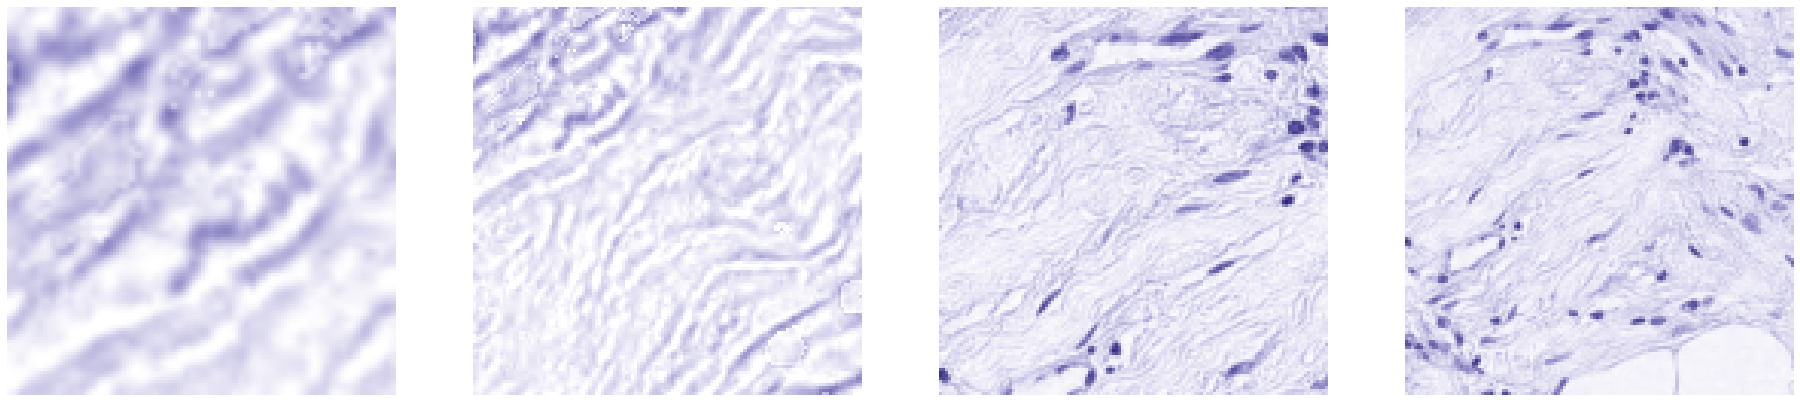

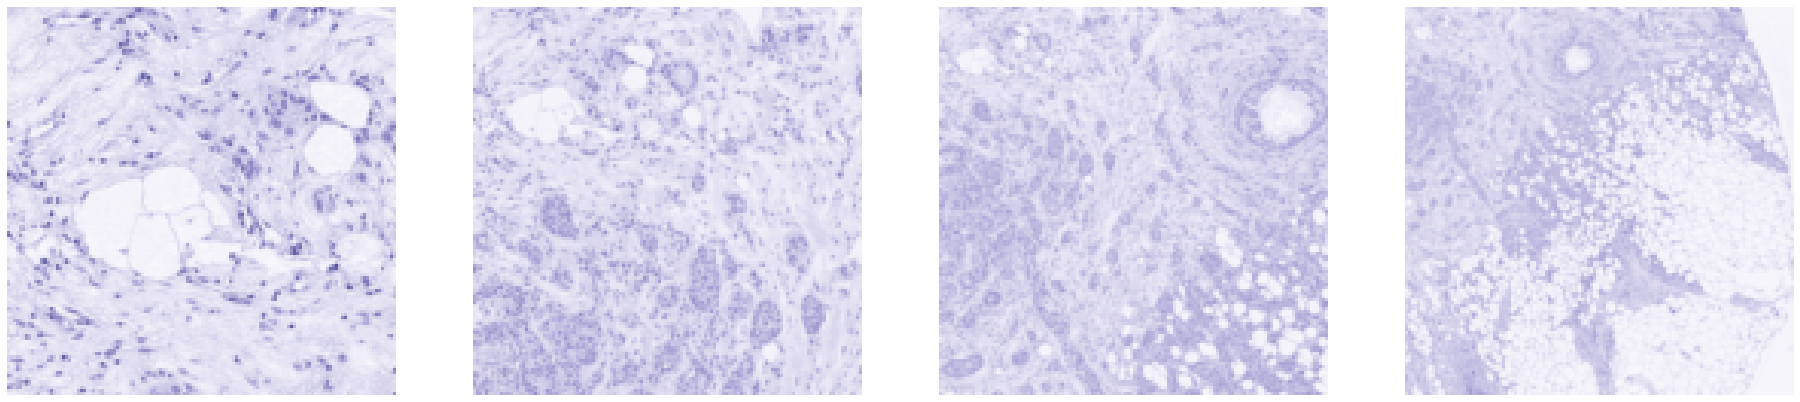

In [3]:
from cucim import CuImage
from cucim.skimage import color
from cucim.skimage.util import img_as_ubyte
import nvidia.dali as dali
import nvidia.dali.fn as fn
import cupy as cp

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
%matplotlib inline

def show_images(image_batch):
    columns = 4
    rows = (batch_size + 1) // (columns)
    fig = plt.figure(figsize = (32,(32 // columns) * rows))
    gs = gridspec.GridSpec(rows, columns)
    for j in range(rows*columns):
        plt.subplot(gs[j])
        plt.axis("off")
        plt.imshow(image_batch.at(j))

def filter_images(image):
    ihc_hed = color.rgb2hed(image)
   
    # Create an RGB image for visualizing hematoxylin stain.
    # (https://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_ihc_color_separation.html#sphx-glr-auto-examples-color-exposure-plot-ihc-color-separation-py)
    null = cp.zeros_like(ihc_hed[:, :, 0])
    ihc_h = color.hed2rgb(cp.stack((ihc_hed[:, :, 0], null, null), axis=-1))
    return img_as_ubyte(ihc_h)

def gen_image(file_name, location_list, size_list, level_list, batch_size):
    image = CuImage(file_name)
    batch = []
    for location, size, level in zip(location_list, size_list, level_list):
        region = image.read_region(location=location, size=size, level=level)
        batch.append(cp.asarray(region))
        if (len(batch) == batch_size):
            yield (batch,)
            batch = []

file_name = "input/image.tif"
location_list = [    (5000, 5000), (5000, 5000), (5000, 5000), (5000, 5000), (5000, 5000), (5000, 5000), (5000, 5000), (5000, 5000)]
size_list     = [        (64, 64),   (128, 128),   (512, 512),   (800, 800),   (800, 800),   (800, 800),   (800, 800),   (800, 800)]
level_list    = [               0,            0,            0,            0,           1,             2,            3,            4]

batch_size = 4
num_threads = 1

pipe = dali.pipeline.Pipeline(batch_size = batch_size, num_threads = num_threads, device_id = 0,
                              exec_async=False, exec_pipelined=False, seed=99)

with pipe:
    input_image = fn.external_source(source=gen_image(file_name, location_list, size_list, level_list, batch_size),
                                     device='gpu', num_outputs=1)
    filtered_image = fn.python_function(input_image[0], function=filter_images, device='gpu', num_outputs=1)
    resize = fn.resize(filtered_image, device='gpu', resize_x=128, resize_y=128)
    pipe.set_outputs(resize)

pipe.build()

while True:
    try:
        output = pipe.run()        
        show_images(output[0].as_cpu())
    except StopIteration:
        break            

### Other Examples

- [DALI: Python Operators](https://docs.nvidia.com/deeplearning/dali/user-guide/docs/examples/custom_operations/python_operator.html): shows you how to run custom Python code by using the family of DALI PythonFunction operators to prototype new augmentations or debug the pipeline.

- [DALI: Processing GPU Data with Python Operators](https://docs.nvidia.com/deeplearning/dali/user-guide/docs/examples/custom_operations/gpu_python_operator.html): shows you how to use the PythonFunction operator on a GPU, using CuPy.

cuCIM's image processing API (`cucim.skimage`) is based on CuPy so you can leverage the example to use cuCIM's API in DALI pipeline.

### Limitations of Python operators

<https://docs.nvidia.com/deeplearning/dali/user-guide/docs/examples/custom_operations/python_operator.html#Limitations-of-Python-Operators>

>The pipelines that incorporate Python operators have to be constructed with `exec_async=False` and `exec_pipelined=False` specified. It is necessary to allow calling Python code from inside of DALI. Those options affect the data pipeline performance.

>As a result of Python threading model, Python operators cannot utilize more than one CPU core. Taking these factors into account, Python operators are very useful for testing, debugging or prototyping but are not considered to be a production level solution to extend DALI.

## Interoperability with DALI through C++ Plugin (future work)

<https://docs.nvidia.com/deeplearning/dali/user-guide/docs/examples/custom_operations/custom_operator/create_a_custom_operator.html#Operator-Definition>

By linking cuCIM's C++ library, we can make universal cuCIM adaptors for `cucim::io::format::IImageFormat` (image file loading/saving) and `cucim::operation::IOperation` (image operation) interfaces.

**Example**

```python
from cucim import CuImage
import nvidia.dali as dali
import nvidia.dali.fn as fn
import nvidia.dali.plugin_manager as plugin_manager
plugin_manager.load_library('./cucim-adaptor/build/libcucim_format.so') # CuCIMReader/CuCIMWriter
plugin_manager.load_library('./cucim-adaptor/build/libcucim_operation.so') # CuCIMOperation

# Input list (can use generator/iterator)
file_list   = ["input/image.tif", "input/image2.tif"]
params_list = [{'location': (100, 100), 'size': (256, 256), 'level': 0}, {'location': (500, 500), 'size': (256, 256), 'level': 1}]
label_list  = ['tumor', 'tissue']

batch_size = 2
num_threads = 1

pipe = dali.pipeline.Pipeline(batch_size = batch_size, num_threads = num_threads, device_id = 0)

with pipe:
    input_image = fn.cucim_reader(file_list, params_list, labels=label_list, device = 'cpu')
    filtered_image = fn.cucim_operation(input_image, name="sobel", axis=1, mode='reflect')
    pipe.set_outputs(filtered_image, labels)

pipe.build()

output = pipe.run()
```


## TODO

- Support DALI's CPU/GPU Tensor: <https://docs.nvidia.com/deeplearning/dali/user-guide/docs/data_types.html#tensor>
- Provide universal cucim adaptors for DALI (for `cucim::io::format::IImageFormat` and `cucim::operation::IOperation` interfaces)